# Analysis of Drug Shortage database

The data we are using for our analysis contains historical data from 2017 to present. All these records has been reported by the Food and Drug Regulations require drug to sellers are not able to meet demand for a product or when they stop selling a product.

Shortage reports have 3 different stages and can be resolved as shown below

# ![image](Shortage_stages.jpg)

In [46]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
# import xlrd
import warnings
# import matplotlib.pyplot as plt
# import seaborn as sns
from prophet import Prophet
warnings.filterwarnings('ignore')

In [47]:
df = pd.read_csv("Shortage data/Zip_Files/shortage_final.csv")

# converting headers in lowercase
df.columns = df.columns.str.lower()

# replacing spaces for "_" in headers
df.columns = df.columns.str.replace(' ', '_')

# Removing NaN actual_start_date and actual_end_date, considering as an incomplete record
df=df.dropna(subset=['actual_start_date','actual_end_date'] )

# Removing Actuals before 2017
df = df.loc[(df['actual_start_date'] >= '2017-01-01')]
# Removing outliers before 2010 for End_date
df = df.loc[(df['actual_end_date'] >= '2010-01-01')]

# Removing duplicates ID Reports
df=df.drop_duplicates("report_id", keep=False)

df.tail()

,report_id,drug_identification_number,report_type,brand_name,company_name,common_or_proper_name,ingredients,strength(s),packaging_size,route_of_administration,...,atc_code,atc_description,anticipated_start_date,actual_start_date,estimated_end_date,actual_end_date,reason,date_created,date_updated,tier_3
17163,21685,2340445.0,Shortage,ZYCLARA,VALEANT CANADA LP/VALEANT CANADA S.E.C.,ZYCLARA,IMIQUIMOD,3.75%,na,TOPICAL,...,D06BB,CHEMOTHERAPEUTICS FOR TOPICAL USE,NaN,2017-09-08,2017-09-22,2017-09-22,Other (Please describe in comments),2017-09-08,2017-09-25,No
17164,52702,2340445.0,Shortage,ZYCLARA,VALEANT CANADA LP/VALEANT CANADA S.E.C.,ZYCLARA,IMIQUIMOD,3.75%,7.5g pump,TOPICAL,...,D06BB,CHEMOTHERAPEUTICS FOR TOPICAL USE,NaN,2019-04-01,NaN,2019-07-12,Other (Please describe in comments),2018-06-20,2019-07-13,No
17165,18241,2257270.0,Shortage,ZYMAR,ALLERGAN INC,ZYMAR 1mL,GATIFLOXACIN,0.3%,1 mL,OPHTHALMIC,...,S01AE,ANTIINFECTIVES,2017-08-03,2017-08-03,2017-09-18,2017-10-06,Disruption of the manufacture of the drug.,2017-08-03,2017-10-13,No
17166,33440,2257270.0,Shortage,ZYMAR,ALLERGAN INC,ZYMAR 1mL,GATIFLOXACIN,0.3%,5mL,OPHTHALMIC,...,S01AE,ANTIINFECTIVES,2019-09-16,2019-09-16,2019-09-20,2019-09-18,Disruption of the manufacture of the drug.,2017-12-18,2019-09-19,No
17167,54338,2243686.0,Shortage,ZYVOXAM,PFIZER CANADA INC,Zyvoxam,LINEZOLID,3G,1x240ml Btl,ORAL,...,J01XX,OTHER ANTIBACTERIALS,NaN,2018-08-21,NaN,2018-10-23,Disruption of the manufacture of the drug.,2018-07-04,2018-10-24,No


Converting start and end date fields from object to datetime64

In [49]:
df['actual_start_date'] = df['actual_start_date'].astype('datetime64[D]')

In [50]:
df['actual_end_date'] = df['actual_end_date'].astype('datetime64[D]')

Fill NaN drug_identification_number into 0, converting as int

In [51]:
df['drug_identification_number'] = df['drug_identification_number'].fillna(0)
df['drug_identification_number'] = df['drug_identification_number'].astype('int')

In [52]:
df.dtypes

report_id                              int64
drug_identification_number             int32
report_type                           object
brand_name                            object
company_name                          object
common_or_proper_name                 object
ingredients                           object
strength(s)                           object
packaging_size                        object
route_of_administration               object
shortage_status                       object
dosage_form(s)                        object
atc_code                              object
atc_description                       object
anticipated_start_date                object
actual_start_date             datetime64[ns]
estimated_end_date                    object
actual_end_date               datetime64[ns]
reason                                object
date_created                          object
date_updated                          object
tier_3                                object
dtype: obj

In [53]:
# Fill Nat end date with today date
# today = datetime.today().strftime('%Y-%m-%d')
# df = df.fillna(today)

Calculating # of Days of shortage = actual - start date

In [54]:
df['Days']= df['actual_end_date']-df['actual_start_date']

In [55]:
# export to .csv to check data consistency
# df.to_csv("data.csv", index=False)

In [56]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13549 entries, 0 to 17167
Columns: 23 entries, report_id to Days
dtypes: datetime64[ns](2), int32(1), int64(1), object(18), timedelta64[ns](1)
memory usage: 2.4+ MB


In [57]:
din = df['drug_identification_number'].mode()
din


0    717002
dtype: int32

In [58]:
col_list = ['actual_start_date', 'Days']
df2 = df[col_list]
df2

,actual_start_date,Days
0,2023-01-09,35 days
1,2022-06-09,11 days
2,2022-10-01,60 days
3,2022-05-04,47 days
4,2022-02-01,93 days
...,...,...
17163,2017-09-08,14 days
17164,2019-04-01,102 days
17165,2017-08-03,64 days
17166,2019-09-16,2 days


Clean outliers, clean data previous to 2017

In [59]:
df2 = df2.loc[(df['actual_start_date'] >= '2017-01-01')]
df2

,actual_start_date,Days
0,2023-01-09,35 days
1,2022-06-09,11 days
2,2022-10-01,60 days
3,2022-05-04,47 days
4,2022-02-01,93 days
...,...,...
17163,2017-09-08,14 days
17164,2019-04-01,102 days
17165,2017-08-03,64 days
17166,2019-09-16,2 days


In [60]:
df2.columns = ['ds', 'y']
df2['y'] = df2['y'].dt.days
df2.head()

,ds,y
0,2023-01-09,35
1,2022-06-09,11
2,2022-10-01,60
3,2022-05-04,47
4,2022-02-01,93


### Training the time series model

In [61]:
p = Prophet(interval_width=0.5, daily_seasonality=True)

Now train the model.

In [62]:
model = p.fit(df2)

12:44:58 - cmdstanpy - INFO - Chain [1] start processing
12:45:14 - cmdstanpy - INFO - Chain [1] done processing


### Making predictions and evaluating performance

In [63]:
future = p.make_future_dataframe(periods=50, freq='D')
future.tail()

,ds
1754,2024-02-05
1755,2024-02-06
1756,2024-02-07
1757,2024-02-08
1758,2024-02-09


In [64]:
forecast_prediction = p.predict(future)
forecast_prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,395.476032,334.046741,575.226354,395.476032,395.476032,58.361804,58.361804,58.361804,-79.460774,...,152.683515,152.683515,152.683515,-14.860937,-14.860937,-14.860937,0.0,0.0,0.0,453.837836
1,2017-01-03,394.404551,124.606489,386.992920,394.404551,394.404551,-141.312664,-141.312664,-141.312664,-79.460774,...,-45.192544,-45.192544,-45.192544,-16.659345,-16.659345,-16.659345,0.0,0.0,0.0,253.091887
2,2017-01-04,393.868810,136.118825,397.264808,393.868810,393.868810,-129.797081,-129.797081,-129.797081,-79.460774,...,-32.994660,-32.994660,-32.994660,-17.341647,-17.341647,-17.341647,0.0,0.0,0.0,264.071729
3,2017-01-06,392.797328,134.642224,377.993875,392.797328,392.797328,-134.703613,-134.703613,-134.703613,-79.460774,...,-36.967088,-36.967088,-36.967088,-18.275750,-18.275750,-18.275750,0.0,0.0,0.0,258.093716
4,2017-01-10,390.654366,127.398433,377.884483,390.654366,390.654366,-143.268636,-143.268636,-143.268636,-79.460774,...,-45.192544,-45.192544,-45.192544,-18.615317,-18.615317,-18.615317,0.0,0.0,0.0,247.385730


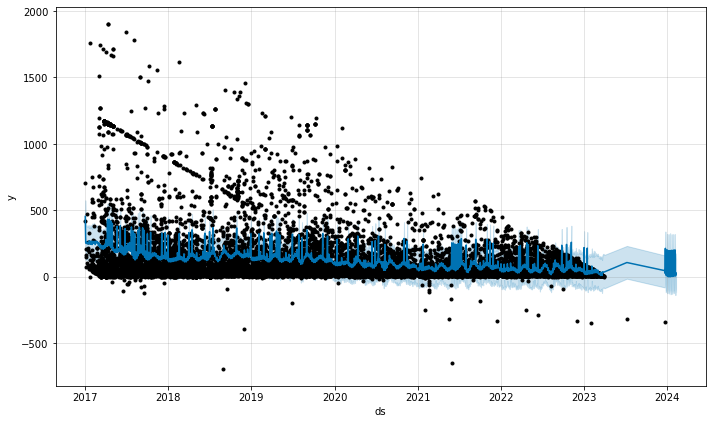

In [65]:
plot1 = p.plot(forecast_prediction)

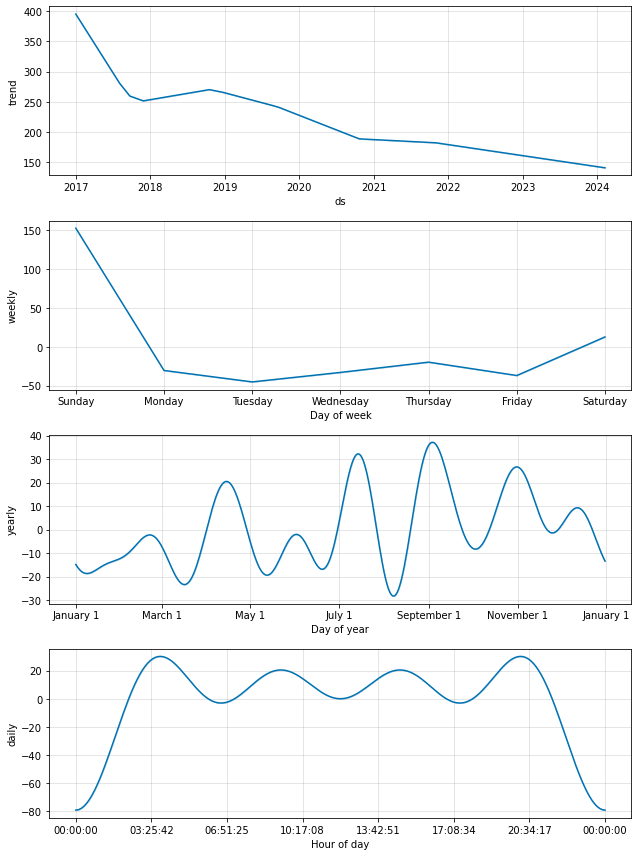

In [66]:
plot2 = p.plot_components(forecast_prediction)